In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [4]:
# 다른 방법
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/energy_3years.csv",
                 parse_dates=['timestamp'])

df.set_index("timestamp", inplace=True)

print(df.shape)
df[:3]

In [9]:
df_down = df.resample('D').sum()
print(df_down.shape)
df_down[:3]

(1096, 2)


,load,temp
timestamp,,
2012-01-01,71562.0,906.333333
2012-01-02,76841.0,897.666667
2012-01-03,87887.0,418.333333


In [10]:
df_down['temp_mean'] = df.temp.resample('D').mean()
df_down[:3]

,load,temp,temp_mean
timestamp,,,
2012-01-01,71562.0,906.333333,37.763889
2012-01-02,76841.0,897.666667,37.402778
2012-01-03,87887.0,418.333333,17.430556


## 단변수 시계열 예측

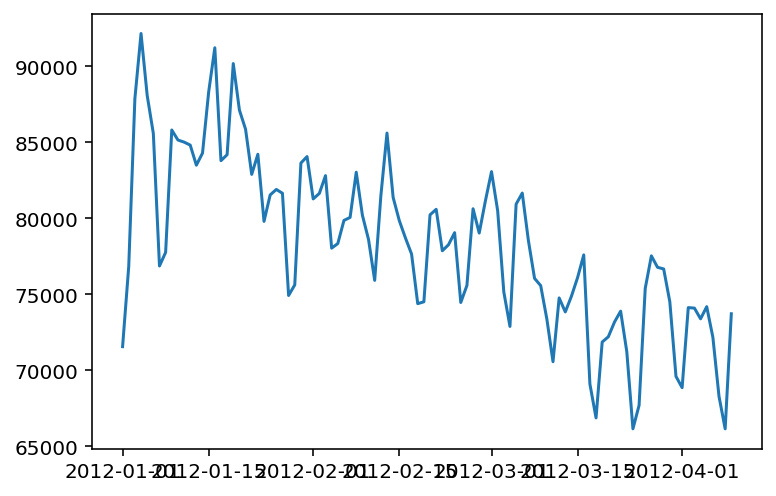

In [11]:
df = df_down.copy()
y = df.load
plt.plot(y[:100])

## 선형 예측

In [12]:
# 데이터 나누기
ratio = 0.75
cut = np.int(len(y)*ratio)
train_data = y[:cut]
test_data = y[cut:]
len(y), len(train_data), len(test_data)

(1096, 822, 274)

In [13]:
def split_seq(data, n_steps):
    x, y = [], []
    for i in range(len(data)):
        if i > len(data) - (n_steps + 1) : break
        x.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(x), np.array(y)

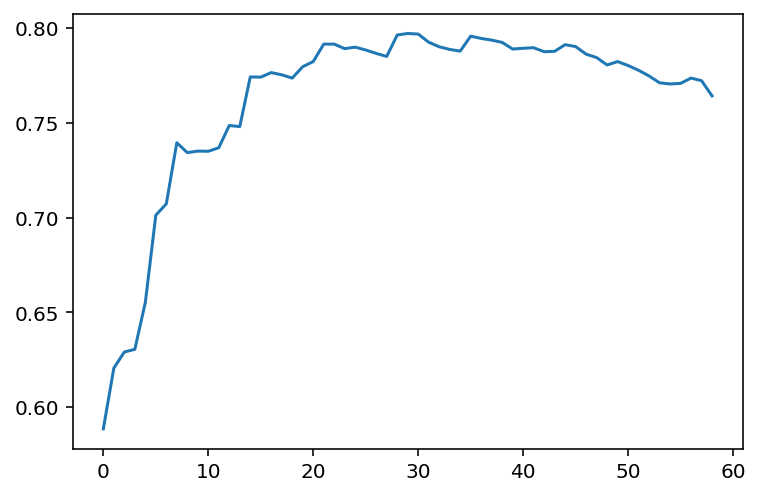

In [14]:
model = LinearRegression()
result = {}
for n_steps in range(1,60,1):
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train) 
    y_pred = model.predict(x_test)
    result[n_steps]= r2_score(y_test, y_pred).round(4)
plt.plot(result.values())

In [15]:
max_steps = max(result, key=result.get)
print("max_steps=", max_steps)

x_train, y_train = split_seq(train_data, max_steps)
x_test, y_test = split_seq(test_data, max_steps)
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)

max_steps= 30


In [17]:
def show_regression_result(y_test, y_pred, N=100):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean().round(4))
    print("max error=", max(error).round(4))
    #  잔차  (residue) 산포도
    print("R2=",r2_score(y_test, y_pred).round(4)) # R2
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.scatter(y_test, error, s=5)
    plt.xlabel('y_test')
    plt.ylabel('error')
    plt.show()

MAE= 2220.2821
max error= 14205.8371
R2= 0.797


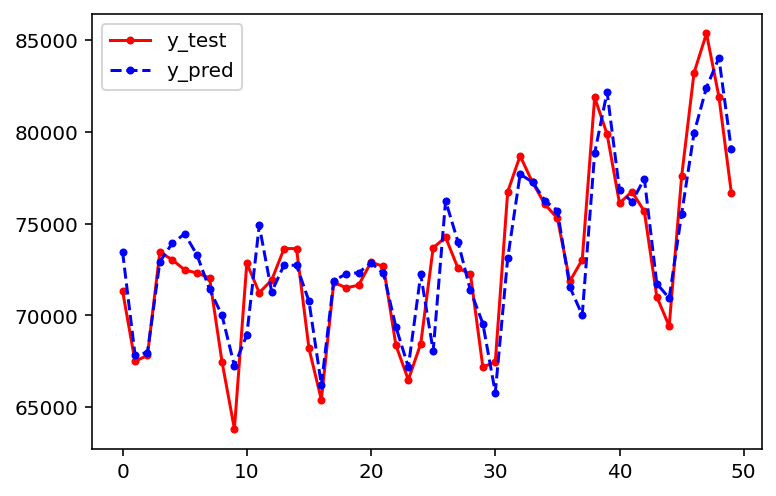

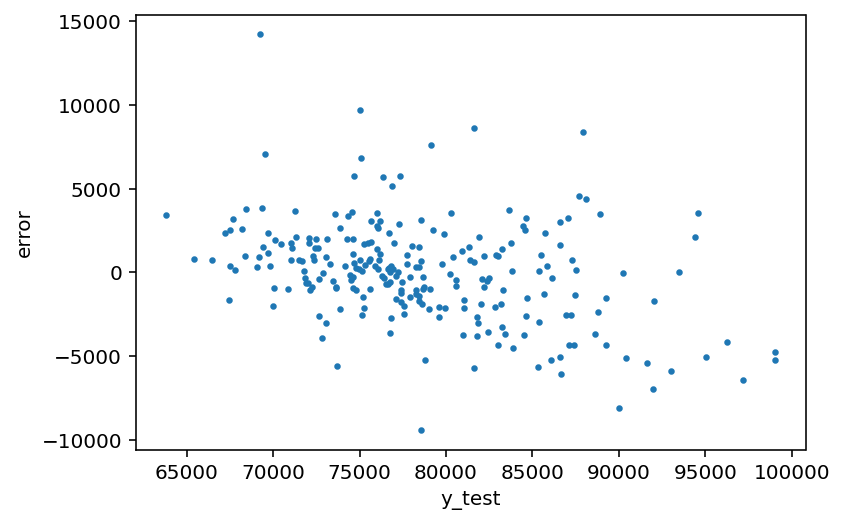

In [18]:
show_regression_result(y_test, y_pred, 50)

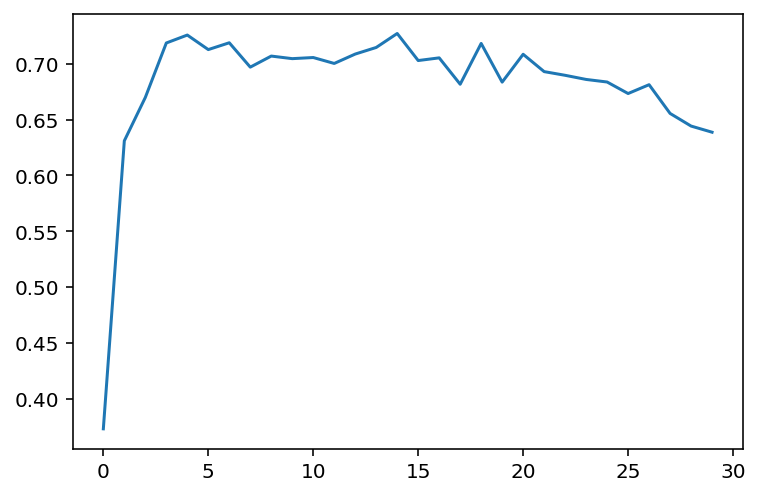

In [19]:
# 랜덤포레스트로 단변수 예측
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=20)
# model = LinearRegression()
result = {}
for n_steps in range(1,60,2):
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train) 
    y_pred = model.predict(x_test)
    result[n_steps]= r2_score(y_test, y_pred).round(4)
plt.plot(result.values())

max_steps= 29
MAE= 2547.8698
max error= 13833.55
R2= 0.7208


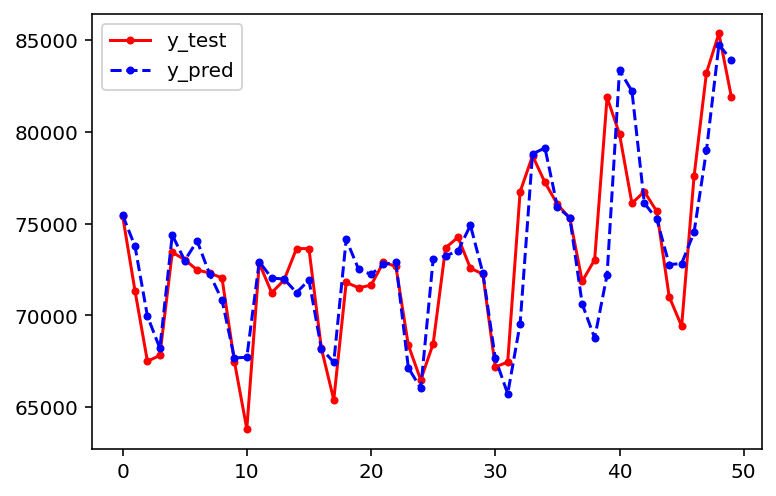

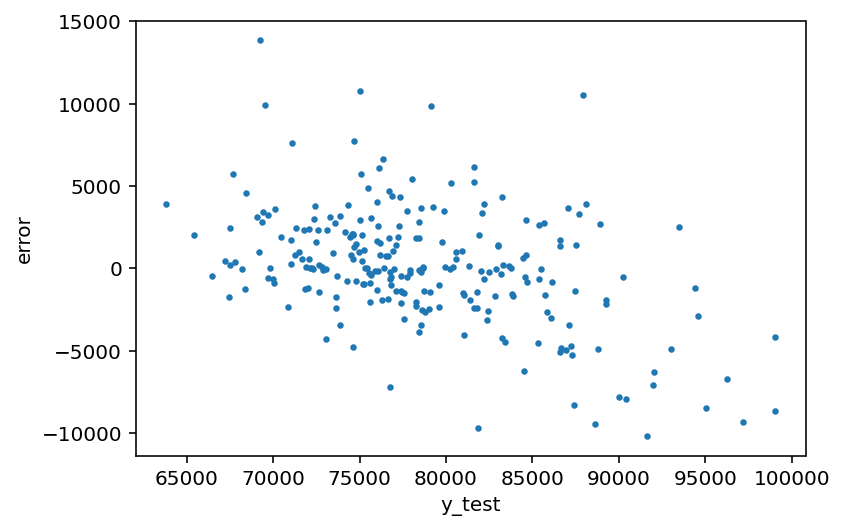

In [20]:
max_steps = max(result, key=result.get)
print("max_steps=", max_steps)

x_train, y_train = split_seq(train_data, max_steps)
x_test, y_test = split_seq(test_data, max_steps)
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)
show_regression_result(y_test, y_pred, 50)

# 특성 추가

## 이동평균 생성
- 데이터프레임을 출력

In [21]:
df["5-mean"] = df.load.rolling(5,min_periods=1).mean()
df[:10]

,load,temp,temp_mean,5-mean
timestamp,,,,
2012-01-01,71562.0,906.333333,37.763889,71562.000000
2012-01-02,76841.0,897.666667,37.402778,74201.500000
2012-01-03,87887.0,418.333333,17.430556,78763.333333
2012-01-04,92168.0,314.666667,13.111111,82114.500000
2012-01-05,88096.0,597.000000,24.875000,83310.800000
2012-01-06,85591.0,621.666667,25.902778,86116.600000
2012-01-07,76869.0,759.666667,31.652778,86122.200000
2012-01-08,77767.0,720.000000,30.000000,84098.200000
2012-01-09,85818.0,606.666667,25.277778,82828.200000


In [22]:
df["20-mean"] = df.load.rolling(20,min_periods=1).mean()
df["10-std"] = df.load.rolling(10, min_periods=1).std().fillna(0)
# df["5-max"] = df.load.rolling(5, min_periods=1).max()
df[:3]

,load,temp,temp_mean,5-mean,20-mean,10-std
timestamp,,,,,,
2012-01-01,71562.0,906.333333,37.763889,71562.000000,71562.000000,0.000000
2012-01-02,76841.0,897.666667,37.402778,74201.500000,74201.500000,3732.816698
2012-01-03,87887.0,418.333333,17.430556,78763.333333,78763.333333,8330.542019


In [23]:
df.columns

Index(['load', 'temp', 'temp_mean', '5-mean', '20-mean', '10-std'], dtype='object')

In [25]:
features = ['load', 'temp_mean', '5-mean', '20-mean', '10-std']
X = df[features]
n_features = len(features)

In [27]:
# 데이터 나누기
ratio = 0.75
cut = np.int(len(X)*ratio)
train_data = X[:cut]
test_data = X[cut:]
len(X), len(train_data), len(test_data)

(1096, 822, 274)

In [28]:
train_data.shape, test_data.shape # 특성 수가 1이 아니라 3으로 늘었다

((822, 5), (274, 5))

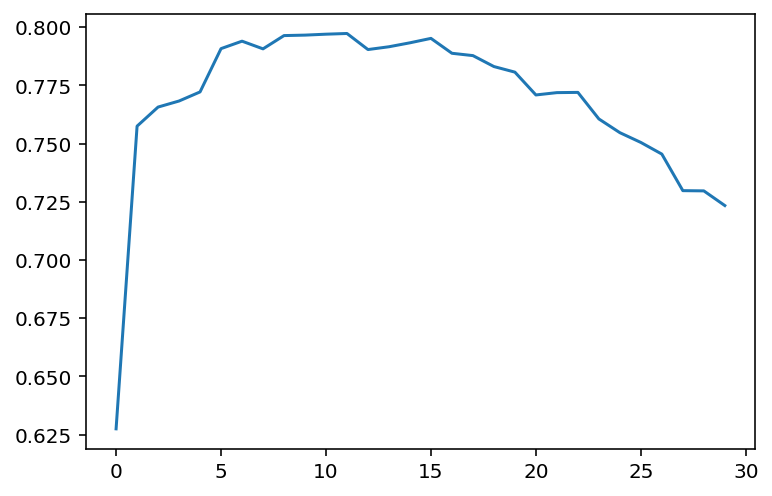

In [29]:
model = LinearRegression()
result = {}
for n_steps in range(1,60,2):
    x_train, y_train = split_seq(train_data.values, n_steps)
    x_train_flat = x_train.reshape(-1, n_steps*n_features)
    x_test, y_test = split_seq(test_data.values, n_steps)
    x_test_flat = x_test.reshape(-1, n_steps*n_features)
    model.fit(x_train_flat, y_train[:,0]) # 주의: 선형모델은 벡터 형의 y값만 구할 수 있다
    y_pred = model.predict(x_test_flat)
    result[n_steps]= r2_score(y_test[:,0], y_pred).round(4)
plt.plot(result.values())

In [30]:
max_steps = max(result, key=result.get)
print("max_steps=", max_steps)

max_steps= 23


MAE= 2195.8283
max error= 13239.1001
R2= 0.7973


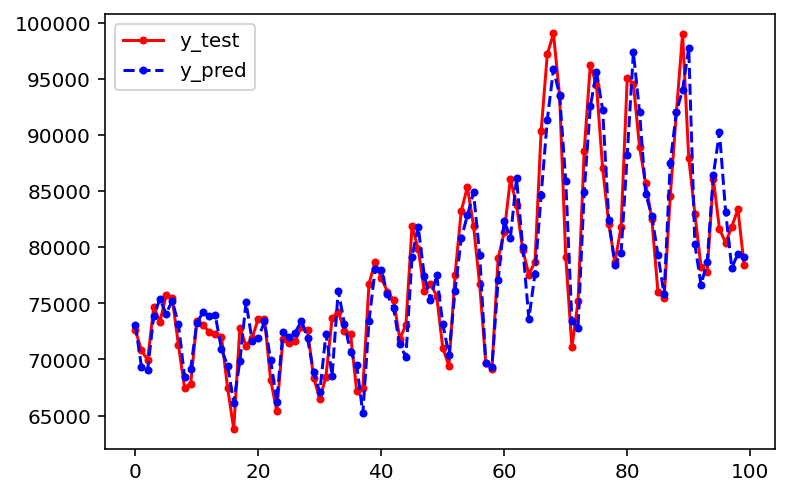

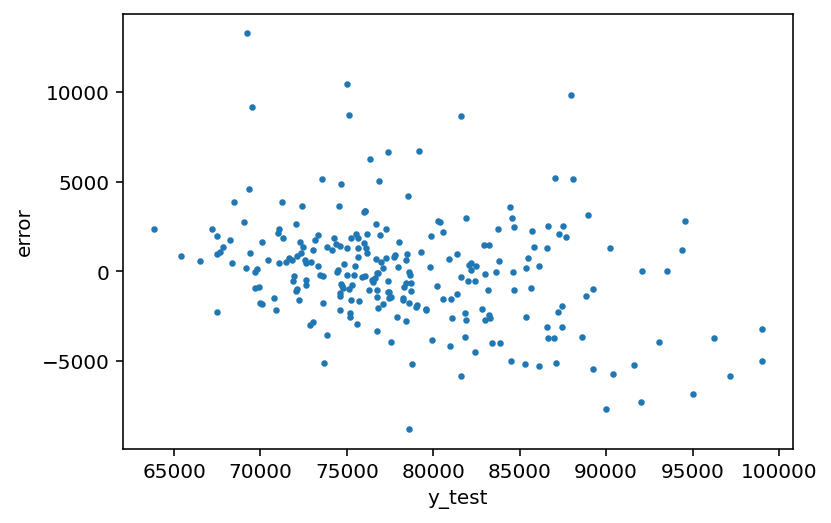

In [31]:
n_steps = max_steps
x_train, y_train = split_seq(train_data.values, n_steps)
x_train_flat = x_train.reshape(-1, n_steps*n_features)

x_test, y_test = split_seq(test_data.values, n_steps)
x_test_flat = x_test.reshape(-1, n_steps*n_features)

model.fit(x_train_flat, y_train[:,0]) 
y_pred = model.predict(x_test_flat)

show_regression_result(y_test[:,0], y_pred)

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train_flat)

In [33]:
x_test_sc = scaler.transform(x_test_flat)

MAE= 2196.6889
max error= 13288.9997
R2= 0.7976


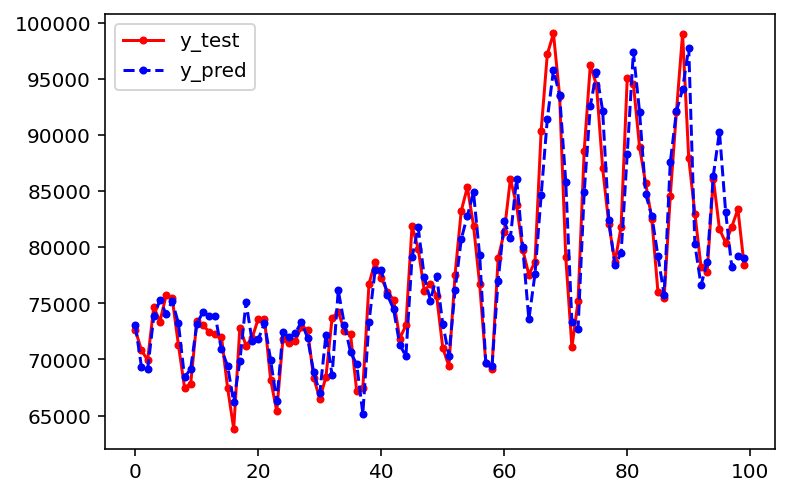

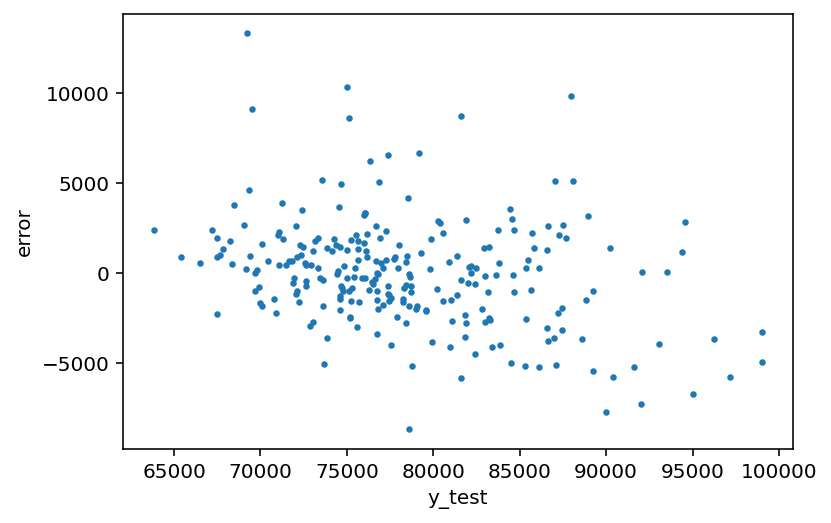

In [34]:
model.fit(x_train_sc, y_train[:,0]) 
y_pred = model.predict(x_test_sc)
show_regression_result(y_test[:,0], y_pred)

In [ ]:
# 과제(1): 단변수 load를 예측하는데 랜덤포레스트를 사용하면 성능이 개선되나? 0.78이상? (과거 며칠치를 사용할 것인지 선정)
# 과제(2): 특성을 임의의 개수를 추가하여 (1)의 성능을 향상시킬 수 있나? (3개,,.???)
# 과제(3): 위에서는 y=load만 예측했는데, y1=load, y2=5-mean, y3=5-std 등 다변수를 동시에 모두 예측하는 모델은?
# 모두 랜덤포레스트를 사용 (중요)

In [35]:
X[:3]

,load,temp_mean,5-mean,20-mean,10-std
timestamp,,,,,
2012-01-01,71562.0,37.763889,71562.000000,71562.000000,0.000000
2012-01-02,76841.0,37.402778,74201.500000,74201.500000,3732.816698
2012-01-03,87887.0,17.430556,78763.333333,78763.333333,8330.542019


In [38]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=50)

In [42]:
y_train.shape

(799, 5)

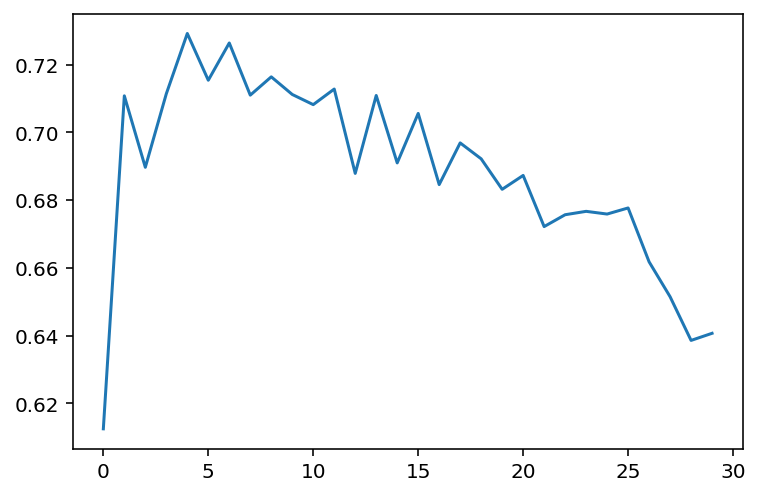

In [39]:
# model = LinearRegression()
result = {}
for n_steps in range(1,60,2):
    x_train, y_train = split_seq(train_data.values, n_steps)
    x_train_flat = x_train.reshape(-1, n_steps*n_features)
    x_test, y_test = split_seq(test_data.values, n_steps)
    x_test_flat = x_test.reshape(-1, n_steps*n_features)
    model.fit(x_train_flat, y_train) # 주의: 선형모델은 벡터 형의 y값만 구할 수 있다
    y_pred = model.predict(x_test_flat)
    result[n_steps]= r2_score(y_test, y_pred).round(4)
plt.plot(result.values())

In [40]:
max(result, key=result.get)

9

MAE= 2680.8134
max error= 12979.78
R2= 0.7075


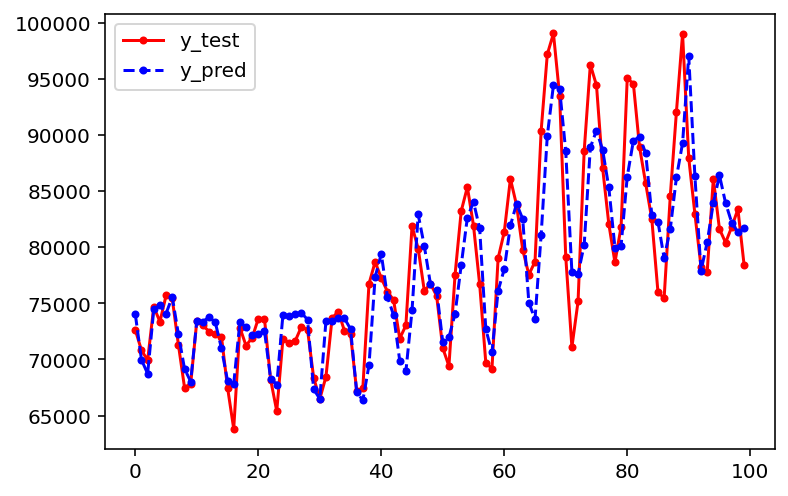

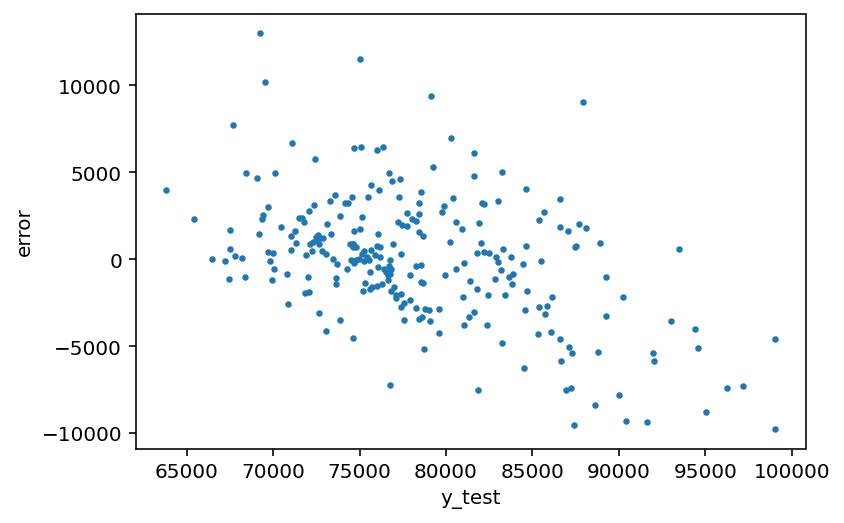

In [41]:
n_steps = max_steps
x_train, y_train = split_seq(train_data.values, n_steps)
x_train_flat = x_train.reshape(-1, n_steps*n_features)

x_test, y_test = split_seq(test_data.values, n_steps)
x_test_flat = x_test.reshape(-1, n_steps*n_features)

model.fit(x_train_flat, y_train[:,0]) 
y_pred = model.predict(x_test_flat)

show_regression_result(y_test[:,0], y_pred)

# 다차항 추가
- Polynomial

In [134]:
x = np.arange(12).reshape(6,2)
x

array([[ 0,  1],
       [ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11]])

In [139]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly.fit_transform(x)

array([[  1.,   0.,   1.,   0.,   0.,   1.],
       [  1.,   2.,   3.,   4.,   6.,   9.],
       [  1.,   4.,   5.,  16.,  20.,  25.],
       [  1.,   6.,   7.,  36.,  42.,  49.],
       [  1.,   8.,   9.,  64.,  72.,  81.],
       [  1.,  10.,  11., 100., 110., 121.]])

In [140]:
df_power[:3]

,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000


In [144]:
scaler.fit_transform(df_power[["load", "temp"]])

array([[-1.07297728, -0.81527672],
       [-1.32095427, -0.78080188],
       [-1.52287839, -0.91870124],
       ...,
       [ 0.65046277, -1.59096059],
       [ 0.34580533, -1.67714769],
       [ 0.07303064, -1.67714769]])

In [145]:
poly.fit_transform(scaler.fit_transform(df_power[["load", "temp"]])).round(4)

array([[ 1.    , -1.073 , -0.8153,  1.1513,  0.8748,  0.6647],
       [ 1.    , -1.321 , -0.7808,  1.7449,  1.0314,  0.6097],
       [ 1.    , -1.5229, -0.9187,  2.3192,  1.3991,  0.844 ],
       ...,
       [ 1.    ,  0.6505, -1.591 ,  0.4231, -1.0349,  2.5312],
       [ 1.    ,  0.3458, -1.6771,  0.1196, -0.58  ,  2.8128],
       [ 1.    ,  0.073 , -1.6771,  0.0053, -0.1225,  2.8128]])

# 평활화 (smoothing)
- ewma: Exponentially-weighted moving average

In [92]:
df[:10]

,load,temp,temp_mean,5-mean,10-mean,5-std,5-max
timestamp,,,,,,,
2012-01-01,71562.0,906.333333,37.763889,71562.000000,71562.000000,0.000000,71562.0
2012-01-02,76841.0,897.666667,37.402778,74201.500000,74201.500000,3732.816698,76841.0
2012-01-03,87887.0,418.333333,17.430556,78763.333333,78763.333333,8330.542019,87887.0
2012-01-04,92168.0,314.666667,13.111111,82114.500000,82114.500000,9549.165356,92168.0
2012-01-05,88096.0,597.000000,24.875000,83310.800000,83310.800000,8691.696480,92168.0
2012-01-06,85591.0,621.666667,25.902778,86116.600000,83690.833333,5700.543685,92168.0
2012-01-07,76869.0,759.666667,31.652778,86122.200000,82716.285714,5689.156062,92168.0
2012-01-08,77767.0,720.000000,30.000000,84098.200000,82097.625000,6627.178034,92168.0
2012-01-09,85818.0,606.666667,25.277778,82828.200000,82511.000000,5134.430222,88096.0


In [147]:
df['5EWMA'] = df['load'].ewm(span=5).mean()
df[:10]

,load,temp,temp_mean,5-mean,10-mean,5-std,5-max,20-mean,30-mean,5EWMA
timestamp,,,,,,,,,,
2012-01-01,71562.0,906.333333,37.763889,71562.000000,71562.000000,0.000000,71562.0,71562.000000,71562.000000,71562.000000
2012-01-02,76841.0,897.666667,37.402778,74201.500000,74201.500000,3732.816698,76841.0,74201.500000,74201.500000,74729.400000
2012-01-03,87887.0,418.333333,17.430556,78763.333333,78763.333333,8330.542019,87887.0,78763.333333,78763.333333,80961.947368
2012-01-04,92168.0,314.666667,13.111111,82114.500000,82114.500000,9549.165356,92168.0,82114.500000,82114.500000,85616.769231
2012-01-05,88096.0,597.000000,24.875000,83310.800000,83310.800000,8691.696480,92168.0,83310.800000,83310.800000,86568.511848
2012-01-06,85591.0,621.666667,25.902778,86116.600000,83690.833333,5700.543685,92168.0,83690.833333,83690.833333,86211.315789
2012-01-07,76869.0,759.666667,31.652778,86122.200000,82716.285714,5689.156062,92168.0,82716.285714,82716.285714,82903.618747
2012-01-08,77767.0,720.000000,30.000000,84098.200000,82097.625000,6627.178034,92168.0,82097.625000,82097.625000,81121.892308
2012-01-09,85818.0,606.666667,25.277778,82828.200000,82511.000000,5134.430222,88096.0,82511.000000,82511.000000,82729.067863


<AxesSubplot:xlabel='timestamp'>

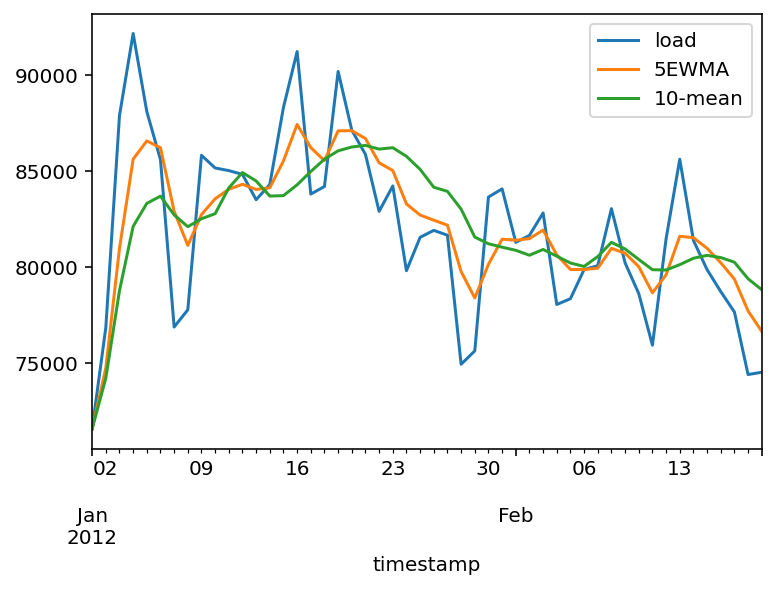

In [148]:
df[['load','5EWMA', "10-mean"]][:50].plot()

## 샘플 시프트

In [102]:
df.load.shift(1)

timestamp
2012-01-01        NaN
2012-01-02    71562.0
2012-01-03    76841.0
2012-01-04    87887.0
2012-01-05    92168.0
               ...   
2014-12-27    74155.0
2014-12-28    73845.0
2014-12-29    74678.0
2014-12-30    84486.0
2014-12-31    88810.0
Freq: D, Name: load, Length: 1096, dtype: float64

In [104]:
df.load.shift(-1).fillna(0)

timestamp
2012-01-01    76841.0
2012-01-02    87887.0
2012-01-03    92168.0
2012-01-04    88096.0
2012-01-05    85591.0
               ...   
2014-12-27    74678.0
2014-12-28    84486.0
2014-12-29    88810.0
2014-12-30    89246.0
2014-12-31        0.0
Freq: D, Name: load, Length: 1096, dtype: float64

# 차분 (difference)
- 시계열 데이터의 차분을 예측하는 경우
- 차분을 예측하는 것이 더 어렵다 (점수가 낮게 나온다)

In [111]:
df.load.diff(1)

timestamp
2012-01-01        NaN
2012-01-02     5279.0
2012-01-03    11046.0
2012-01-04     4281.0
2012-01-05    -4072.0
               ...   
2014-12-27     -310.0
2014-12-28      833.0
2014-12-29     9808.0
2014-12-30     4324.0
2014-12-31      436.0
Freq: D, Name: load, Length: 1096, dtype: float64

In [112]:
df.load.diff(-1)

timestamp
2012-01-01    -5279.0
2012-01-02   -11046.0
2012-01-03    -4281.0
2012-01-04     4072.0
2012-01-05     2505.0
               ...   
2014-12-27     -833.0
2014-12-28    -9808.0
2014-12-29    -4324.0
2014-12-30     -436.0
2014-12-31        NaN
Freq: D, Name: load, Length: 1096, dtype: float64